In [9]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from colour.models import eotf_inverse_ST2084

contrast_ratio = 1000000
d_max_nits = 100
d_min_nits = d_max_nits / contrast_ratio
d_max = eotf_inverse_ST2084(d_max_nits)
d_min = eotf_inverse_ST2084(d_min_nits)
s_min = 0.0
s_nits_avg = 144
s_avg = eotf_inverse_ST2084(s_nits_avg)
k_adaptation = 0.7
k_min = 0.1
k_max = 0.8
t_strength = 1.5
t_offset = 0.2

s_contrasts = [0.0, 0.2, 0.5, 1.0]
peak_nits = [10, 20, 50, 100, 400, 800, 1000, 4000, 10000]
df_by_max_nits = {}
for s_max_nits in peak_nits:
    df = pd.DataFrame()
    for s_contrast in s_contrasts:
        
        s_max = eotf_inverse_ST2084(s_max_nits)

        t_knee = max(min(((s_avg - s_min) / (s_max - s_min)), k_max), k_min)
        s_knee = t_knee * (s_max - s_min) + s_min
        
        d_pre = t_knee * (d_max - d_min) + d_min
        d_kmin = k_min * d_max + (1 - k_min) * d_min
        d_kmax = k_max * d_max + (1 - k_max) * d_min
        
        d_knee = k_adaptation * d_pre + (1 - k_adaptation) * s_knee
        
        m_slope = (d_knee - d_min) / (s_knee - s_min)
        
        r = s_max / d_max - 1
        r_tuned = min(max(t_strength * r, t_offset), t_offset + 1)
        
        g_slope = 1 - s_contrast
        
        m = m_slope ** (g_slope * r_tuned)
        
        i_min = s_min - s_knee
        i_max = s_max - s_knee
        
        o_min = d_min - d_knee
        o_max = d_max - d_knee
        
        p_a = (o_min - (m * i_min)) / (i_min * i_min)
        p_b = m
        
        t = 2 * i_max * i_max
        
        q_a = (m * i_max - o_max) / (i_max * t)
        q_b = -3 * ((m * i_max - o_max) / t)
        q_c = m
        
        upper_range = np.arange(s_knee, s_max + 0.001, 0.001)
        upper_delta = upper_range - s_knee
        d_upper_1 = q_a * (upper_delta ** 3)
        d_upper_2 = q_b * (upper_delta ** 2)
        d_upper_3 = q_c * upper_delta
        d_upper = d_upper_1 + d_upper_2 + d_upper_3 + d_knee
        
        lower_range = np.arange(s_min, s_knee, 0.001)
        lower_delta = lower_range - s_knee
        d_lower_1 = p_a * (lower_delta ** 2)
        d_lower_2 = p_b * lower_delta
        d_lower = d_lower_1 + d_lower_2 + d_knee
        
        input_signal = np.concatenate((lower_range, upper_range))
        output_signal = np.concatenate((d_lower, d_upper))
        
        if 'input' not in df.columns:
            df['input'] = input_signal
        df[f'{s_contrast}'] = output_signal
    out = f'/media/home-media/docs/calibration/tonemapping/greyscale/s_contrast_peak{s_max_nits}_avg{s_nits_avg}.pkl'
    if not os.path.exists(out):
        df.to_pickle(out)
    df_by_max_nits[s_max_nits] = df
f = [f'{k}: {len(v)}' for k,v in df_by_max_nits.items()]
f

['10: 301',
 '20: 359',
 '50: 443',
 '100: 510',
 '400: 655',
 '800: 730',
 '1000: 754',
 '4000: 905',
 '10000: 1002']

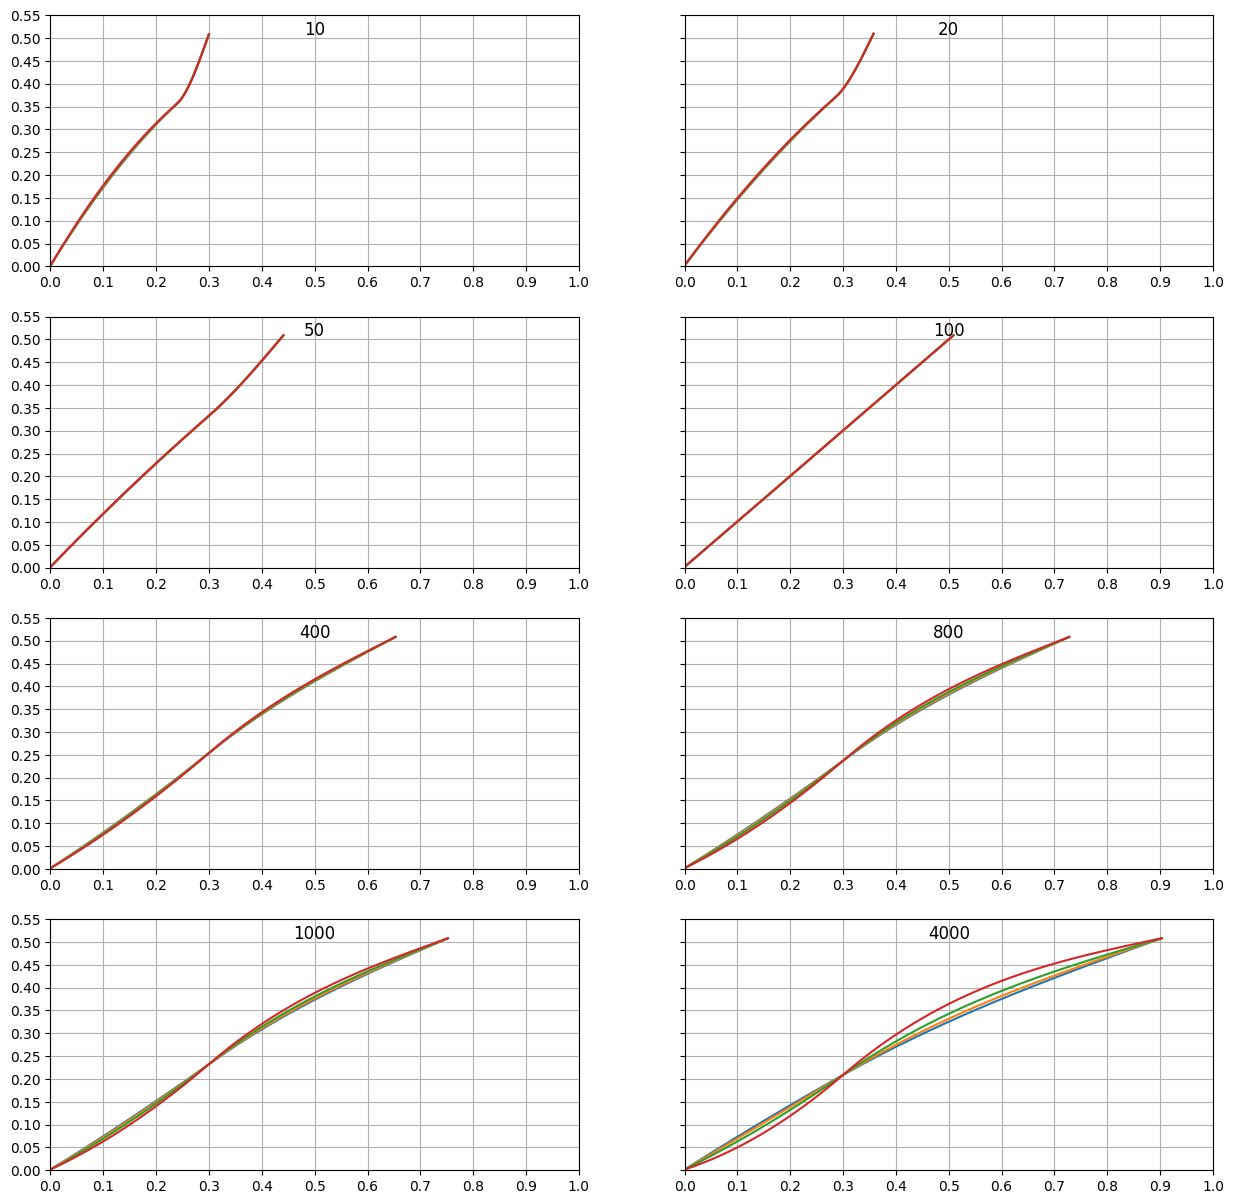

In [92]:
fig, axs = plt.subplots(4, 2, sharex=False, sharey=True, figsize=(15,15))

for ax, s_max_nits in zip(axs.flat, peak_nits):
    df = df_by_max_nits[s_max_nits]
    for c in df.columns:
        if c != 'input':
            ax.plot(df['input'], df[c], label=c)
    ax.grid(True)
    ax.set_title(f'{s_max_nits}', y=1.0, pad=-14)
    ax.set_xlim(0, 1)
    ax.set_xticks(np.arange(0.0, 1.0001, 0.1))
# plt.plot(input_signal, input_signal, '--')
# input_min = 0.0
# s_max = df['input'].max()
# tick_interval = 0.1

plt.ylim(0, 0.5)
_ = plt.yticks(np.arange(0.0, 0.550001, 0.05))
# plt.title(f'Max Nits: {s_max_nits}')
# plt.legend()
# plt.grid()
# plt.show()

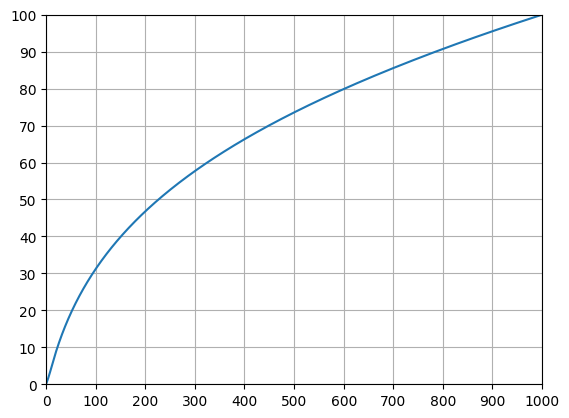

In [32]:
from colour.models import eotf_inverse_ST2084, eotf_ST2084

input_nits = eotf_inverse_ST2084(input_signal)
input_nits_min = eotf_ST2084(input_min)
input_nits_max = eotf_ST2084(input_max)

plt.plot(eotf_ST2084(input_signal), eotf_ST2084(output_signal))
# plt.plot(input_nits, input_nits, '--')
plt.xlim(0, s_max_nits)
plt.ylim(0, d_max_nits)
plt.xticks(np.arange(0, s_max_nits + 1, s_max_nits / 10))
plt.yticks(np.arange(0, d_max_nits + 1, d_max_nits / 10))
plt.grid()
plt.show()


In [106]:
eotf_ST2084([0.23, 0.265, 0.48, 0.5])

eotf_inverse_ST2084([80, 100])

array([ 0.48585677,  0.50807842])